# Load data

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K

In [2]:
def normalize_mid_points(X):
    """Calculate middle point between two hips 
         and substract this point from other coordinates
       Returns:
         normalized coords with concatenated mid point
        """
    left_hip, right_hip = 11, 12
    N = X.shape[0]
    mid_points = (X[:, left_hip, :] + X[:, right_hip, :]) / 2
    mp = mid_points.reshape(N, 1, 3)
    x_n = X - mp
    return np.concatenate([x_n, mp], axis=1).reshape(N, 54)


def read_data(name, normalize=True):
    # print(name)
    with open(f'data/labels/{name}') as f:
        labels = f.readlines()
    
    N = int(re.findall(r'\d+', labels[0])[0])
    X = np.load(f'data/keypoints/{name}.npy')
    print(X.shape)
    X = X.reshape((N, 17, 3))
    y = np.zeros(N, dtype=int)
    
    for lab in labels:
        C = re.findall(r'\d:', lab)

        if len(C) == 1:
            C = int(C[0][0])
            idxs = re.findall(r'\d+-\d+', lab)
            for idx in idxs:
                start, stop = idx.split('-')
                y[int(start): int(stop)] = C
    if normalize:
        X = normalize_mid_points(X)
    else:
        X = X.reshape(N, 51)
    
    return X, y

In [3]:
X_list, y_list = [], []

In [4]:
files = os.listdir('data/labels/')
for f in files:
    X, y = read_data(f)
    X_list.append(X)
    y_list.append(y)

(1200, 1, 1, 17, 3)
(746, 1, 1, 17, 3)
(993, 1, 1, 17, 3)
(703, 1, 1, 17, 3)
(1051, 1, 1, 17, 3)
(1100, 1, 1, 17, 3)
(792, 1, 1, 17, 3)
(643, 1, 1, 17, 3)
(802, 1, 1, 17, 3)
(952, 1, 1, 17, 3)
(1186, 1, 1, 17, 3)
(858, 1, 1, 17, 3)


In [5]:
X_train = np.concatenate(X_list)
y_train = np.concatenate(y_list)

In [6]:
X_train.shape, y_train.shape

((11026, 54), (11026,))

In [7]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

feature_names = []
for name in list(KEYPOINT_DICT.keys()):
    feature_names.append(name+'-x')
    feature_names.append(name+'-y')
    feature_names.append(name+'-z')
feature_names.append('mid_point-x')
feature_names.append('mid_point-y')
feature_names.append('mid_point-z')

In [8]:
df = pd.DataFrame(data=X, columns=feature_names)

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,858.0,-0.234194,0.014294,-0.279006,-0.244493,-0.236618,-0.226024,-0.187483
nose-y,858.0,-0.149767,0.046468,-0.319833,-0.164501,-0.144609,-0.123789,-0.027822
nose-z,858.0,-0.194197,0.105666,-0.467655,-0.267711,-0.190982,-0.114963,0.083157
left_eye-x,858.0,-0.248255,0.013818,-0.287336,-0.258409,-0.250369,-0.240225,-0.205956
left_eye-y,858.0,-0.139566,0.049755,-0.313134,-0.159103,-0.135139,-0.110906,-0.008235
left_eye-z,858.0,-0.177569,0.110876,-0.467530,-0.252619,-0.181847,-0.100234,0.145425
right_eye-x,858.0,-0.248126,0.013645,-0.287846,-0.257980,-0.250150,-0.240524,-0.205641
right_eye-y,858.0,-0.144553,0.046327,-0.314587,-0.158480,-0.138786,-0.117951,-0.029218
right_eye-z,858.0,-0.189417,0.105608,-0.443357,-0.267361,-0.191248,-0.113748,0.103044
left_ear-x,858.0,-0.253142,0.011665,-0.277814,-0.261889,-0.254294,-0.245789,-0.218496


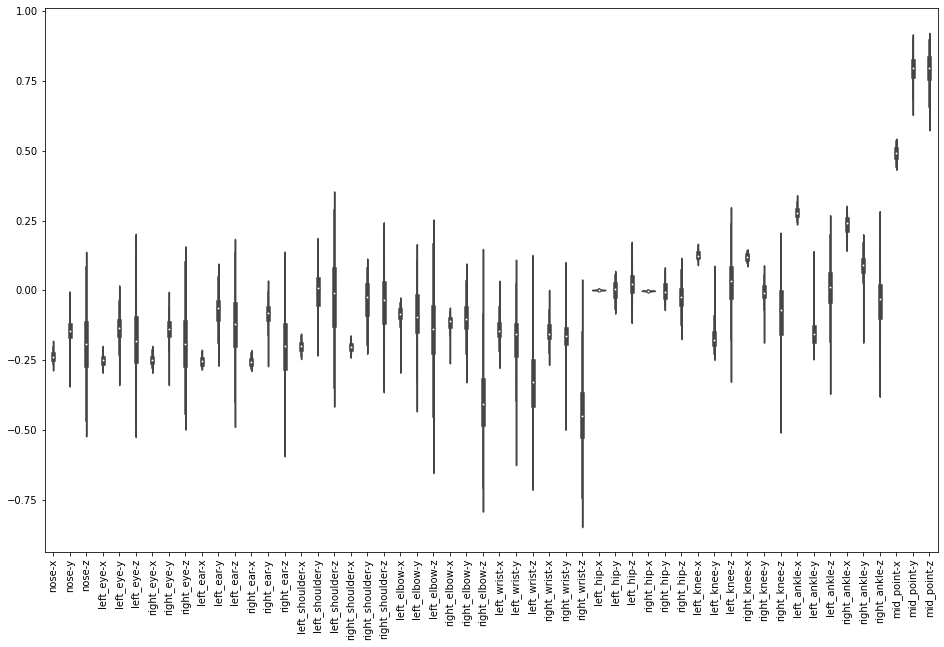

In [10]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [11]:
df['y'] = y

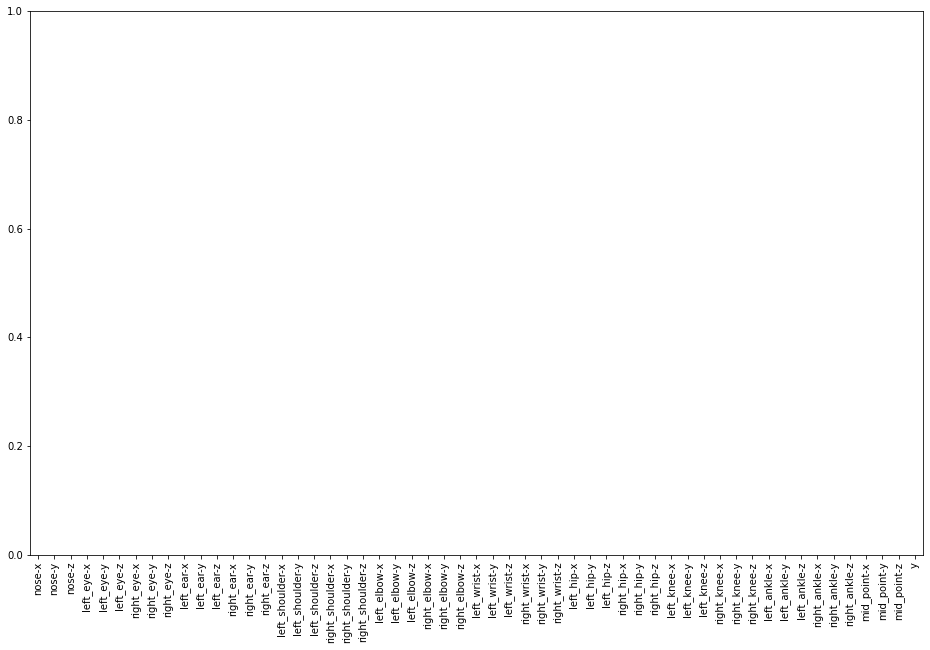

In [12]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df[df.y==2])
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
batch_size=16
N = X_train.shape[0] // batch_size

In [14]:
X = X_train[:N*batch_size].reshape(-1, batch_size, 54)
y = y_train[:N*batch_size].reshape(-1, batch_size, 1)
X.shape, y.shape

((689, 16, 54), (689, 16, 1))

## LSTM

In [15]:
y = K.utils.to_categorical(y, num_classes=7)
X = tf.constant(X)

2021-10-30 19:35:26.137169: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
def build_model(reccur_features=128, df1=64, df2=128, l2=1e-3):
    lstm = K.layers.LSTM(reccur_features,
                         stateful=True,
                         return_sequences=True
                        )
    dense1 = K.layers.Dense(df1)
    dense2 = K.layers.Dense(df2)
    out = K.layers.Dense(7, activation='sigmoid')

    model = K.Sequential([lstm, dense1, dense2, out])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = build_model()

In [17]:
history = model.fit(X, y, batch_size=1, validation_split=0.2, epochs=50)

2021-10-30 19:35:26.218687: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-30 19:35:26.236997: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3912000000 Hz


Epoch 1/50
551/551 [==============================] - 4s 4ms/step - loss: 1.4074 - accuracy: 0.5449 - val_loss: 1.2803 - val_accuracy: 0.5847
Epoch 2/50
551/551 [==============================] - 2s 4ms/step - loss: 1.1588 - accuracy: 0.6053 - val_loss: 1.0868 - val_accuracy: 0.6182
Epoch 3/50
551/551 [==============================] - 2s 4ms/step - loss: 1.0120 - accuracy: 0.6455 - val_loss: 1.0329 - val_accuracy: 0.6277
Epoch 4/50
551/551 [==============================] - 2s 4ms/step - loss: 0.9398 - accuracy: 0.6652 - val_loss: 1.0271 - val_accuracy: 0.6273
Epoch 5/50
551/551 [==============================] - 2s 4ms/step - loss: 0.8662 - accuracy: 0.6935 - val_loss: 1.1613 - val_accuracy: 0.5942
Epoch 6/50
551/551 [==============================] - 2s 4ms/step - loss: 0.8146 - accuracy: 0.7033 - val_loss: 0.9805 - val_accuracy: 0.6612
Epoch 7/50
551/551 [==============================] - 2s 4ms/step - loss: 0.7932 - accuracy: 0.7155 - val_loss: 1.0757 - val_accuracy: 0.6703
Epoch 

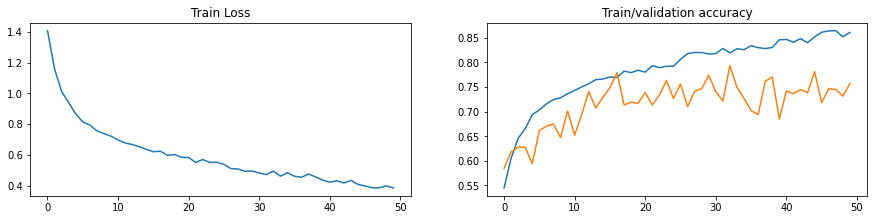

In [18]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

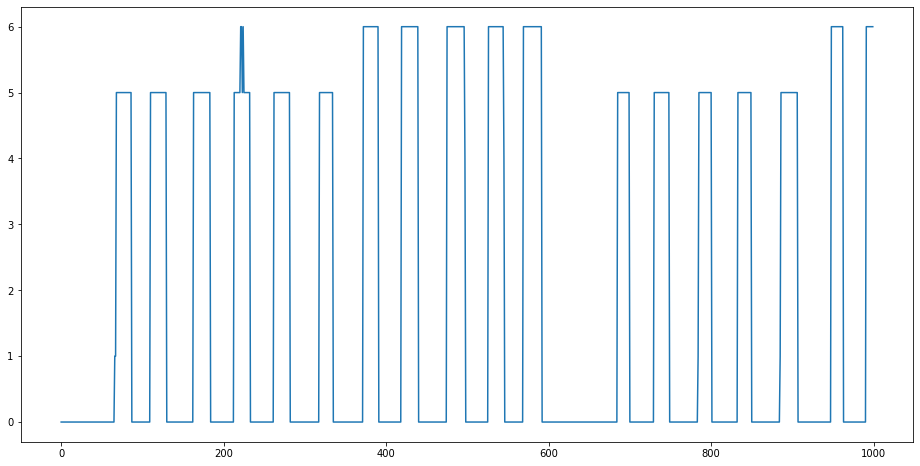

In [19]:
x = tf.reshape(X, (1, -1, 54))
y_pred = np.argmax(model(x[:, :1000, :]).numpy(), axis=-1).ravel()

plt.figure(figsize=(16, 8))
plt.plot(y_pred)

## Conclusion:
May be we need better feature engineering to overfit model on small dataset.